In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
from bs4 import BeautifulSoup

%matplotlib inline

### Importing the datasets 

In [3]:
#RateBeer and Beer Advocate matched website data :

df_beer = pd.read_csv("matched_beer_data/beers.csv", header=1)
df_breweries  = pd.read_csv("matched_beer_data/breweries.csv", header=1)
df_users = pd.read_csv("matched_beer_data/users.csv", header=1)
df_rating = pd.read_csv("matched_beer_data/ratings.csv", header=1)
df_users_approx = pd.read_csv("matched_beer_data/users_approx.csv", header=1)

#Display all columns
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')


### Data preprocessing:

**IMPORTING NEW DATASET ABOUT THE LOCATIONS'SUPERFICIES AND CLEANING THEM**

In [4]:
#wikipedia dataset for states (US) superficies
wiki_url_4usa = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_area'
#Get the html of the pages
response_us = requests.get(wiki_url_4usa)
soup_us = BeautifulSoup(response_us.text,'lxml')

#Find the useful table from in the html and convert it into pandas df 
superficies_list_us = soup_us.find('table', attrs={'class':"wikitable"})
df_superficies_us = pd.read_html(str(superficies_list_us), header=1)[0]
display(df_superficies_us.columns)

#Clean the datafram
df_superficies_us = df_superficies_us[['State', 'km2']] #Keep only the columns we need
df_superficies_us['State'] = 'United States, ' + df_superficies_us['State'] #add the country name to be consistent with the other dataset
df_superficies_us = df_superficies_us.rename(columns={'State': 'location'}) #rename the column
df_superficies_us = df_superficies_us[:-3] #remove the last 3 rows (not states)
df_superficies_us['km2'] = df_superficies_us['km2'].astype(float) #convert the km2 column to int

#_______________________________________________________________________________________________________________________

#wikipedia dataset for country superficies
wiki_url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area'

#Get the html of the pages
response = requests.get(wiki_url)
soup = BeautifulSoup(response.text,'lxml')

#Find the useful table from in the html and convert it into pandas df 
superficies_list = soup.find('table',attrs={'class':"wikitable"})
df_superficies = pd.read_html(str(superficies_list))[0]
display(df_superficies.columns)


#Keep only the columns we need and clean them
df_superficies = df_superficies[['Country / dependency', 'Total in km2 (mi2)']]
df_superficies.rename(columns={'Country / dependency':'location', 'Total in km2 (mi2)':'km2'}, inplace=True) #rename the columns
df_superficies['km2'] = df_superficies['km2'].str.replace(',', '') #remove the comma
df_superficies['km2'] = df_superficies['km2'].str.split(' ').str[0]  #remove the text in parenthesis (mi2)
df_superficies['location'] = df_superficies['location'].str.replace(r'\s*\([^)]*\)', '', regex=True)  #Remove all parenthesis and text inside in the location (ex : remove (China) in 'Hong Kong (China)')
df_superficies['km2'] = df_superficies['km2'].astype(float) #convert the km2 column to int

#Change the name of the countries to be consistent with the other dataset
df_superficies.location = df_superficies.location.replace({'Slovakia' : 'Slovak Republic', 'North Macedonia' : 'Macedonia', 'Trinidad and Tobago' : 'Trinidad & Tobago'})

#________________________________________________________________

#Dataset for UK coutries superficies to be consistent with the other dataset (breweries and beers)
df_superficies_uk = pd.DataFrame({'location': ['England', 'Scotland', 'Wales', 'Northern Ireland'], 
                                  'km2': [130279, 78772, 20779, 14130]}) #create the dataframe (small so easy to do it manually)

#_______________________________________________________________________________________________________________________

#Concatenate the two first dataframe 
df_superficies_temp = pd.concat([df_superficies, df_superficies_us]) #concatenate the two dataframe
print(np.shape(df_superficies_temp))

#Merging the dataframes with the UK dataframe
df_superficies_tot = pd.concat([df_superficies_temp, df_superficies_uk])
print(np.shape(df_superficies_tot))

Index(['State', 'Rank', 'sq mi', 'km2', 'Rank.1', 'sq mi.1', 'km2.1', '% land',
       'Rank.2', 'sq mi.2', 'km2.2', '% water'],
      dtype='object')

Index(['Unnamed: 0', 'Country / dependency', 'Total in km2 (mi2)',
       'Land in km2 (mi2)', 'Water in km2 (mi2)', '% water', 'Unnamed: 6'],
      dtype='object')

(323, 2)
(327, 2)


**MERGING, CLEANING AND VISUALIZE THE MATCHED DATASETS (BEERS AND BREWERIES)**

In [5]:
#Merge the two dataframes on the brewery_id column with respect to the beers to have access to the location of every beer
df_beer_breweries = pd.merge(df_beer, df_breweries, left_on='brewery_id', right_on='id', how='left')

#Clean the dataframe by dropping the columns that are not useful for the analysis
df_beer_breweries_clean = df_beer_breweries.drop(['beer_wout_brewery_name', 'beer_wout_brewery_name.1', 'style','abv.1', 'id', 'id.1', 'name', 'name.1', 'beer_name.1', 'brewery_name.1', 'location.1', 'nbr_beers.1'], axis=1)


#Choose to keep style from RateBeer and drop the style from Beer Advocate (the style from Beer Advocate is too precise)
df_beer_breweries_clean.rename(columns={'style.1':'style'}, inplace=True)

#In the data set, the features with .1 at the end are the ones from Beer Advocate and the ones without .1 are the ones from RateBeer

In [6]:
#Visualization of the dataframe computed above

tmp = df_beer_breweries_clean.groupby('location').size().reset_index(name='count')
new = df_beer_breweries_clean.groupby('location').avg.mean().reset_index().dropna()

# To fit the state names, we need to rename some of them by removing the country name
new.location = new.location.str.replace('United States, ', '')

#add the count column to the new df
new = pd.merge(new, tmp, on='location', how='left')
#new = new[new['count'] > 5]

#plotly doesn't recognise mauritius so we drop it and we need to add the correct names for the UK countries
new = new[new['location'] != 'Mauritius']
new.location = new.location.replace({'England': 'GB-ENG', 'Scotland': 'GB-SCT', 'Wales': 'GB-WLS', 'Northern Ireland': 'GB-NIR'})


# Replace full state names with abbreviations
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO',
    'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
    }
new['location'] = new['location'].map(state_abbreviations).fillna(new['location'])

#sort new df by avg
new = new.sort_values(by=['avg'], ascending=False)

display(new)

,location,avg,count
54,Ivory Coast,4.440000,1.0
14,Cameroon,4.280000,1.0
161,Uruguay,4.080000,1.0
42,Grenada,4.000000,2.0
129,ME,3.943314,NaN
...,...,...,...
64,Malawi,2.090000,3.0
29,Egypt,2.020000,4.0
0,Albania,1.830000,1.0
59,Lebanon,1.670000,2.0


In [7]:
# Create a world map
#Problem to show the countries from the UK on the map
fig_world = px.choropleth(new, locations='location',
                          locationmode='country names', 
                          color='avg', 
                          hover_name='location', 
                          color_continuous_scale=px.colors.sequential.Plasma,
                          scope='world',
                          projection = 'orthographic') 

fig_world.show()

# Create a USA map
fig_usa = px.choropleth(new, locations='location',
                         locationmode='USA-states', 
                         color='avg', 
                         hover_name='location', 
                         color_continuous_scale=px.colors.sequential.Plasma,
                         scope='usa') 

fig_usa.show()

**MERGING AND CLEANING THE MATCHED DATASETS (SUPERFICIES AND BREWERIES)**

In [8]:
#Merge the dataframe with the superficies dataframe to have access to the superficies of every beer
print(df_superficies_tot.shape)
df_breweries_superficies = pd.merge(df_breweries, df_superficies_tot, on='location', how='left')
print(df_breweries_superficies.shape)

#Drop row with NaN values in km2 column
df_breweries_superficies = df_breweries_superficies.dropna(subset=['km2'])
print(df_breweries_superficies.shape)

#Drop the location with less than 5 breweries (to do a beer trip, we need to have different breweries to visit!)
df_breweries_superficies_flt = df_breweries_superficies.groupby('location').filter(lambda x: len(x) >= 5)
print(df_breweries_superficies_flt.shape)

#In the data set, the features with .1 at the end are the ones from Beer Advocate and the ones without .1 are the ones from RateBeer

(327, 2)
(8535, 11)
(8529, 11)
(8365, 11)


In [9]:
df_breweries_superficies_flt

,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1,diff,sim,km2
0,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5,4959,Northern Ireland,Strangford Lough,5,0.431275,0.889062,14130.0
1,32848,Northern Ireland,The Sheelin Brewery,4,17616,Northern Ireland,Sheelin,2,0.526388,0.863596,14130.0
2,40360,Northern Ireland,Walled City Brewing Company,6,24866,Northern Ireland,Walled City,3,0.527852,0.954183,14130.0
3,40309,Northern Ireland,Ards Brewing Company,7,13538,Northern Ireland,Ards Brewing Co.,13,0.554395,0.896098,14130.0
4,41205,Northern Ireland,Barrahooley Brewery,3,22304,Northern Ireland,Barrahooley Craft Brewery,4,0.602544,0.896205,14130.0
...,...,...,...,...,...,...,...,...,...,...,...
8529,10673,"United States, Indiana",Warbird Brewing Company,6,5358,"United States, Indiana",Warbird Brewing Company,6,0.658297,1.000000,94326.0
8530,34365,France,Brasserie De La Goutte D'Or,0,16083,France,Goutte dOr,24,0.412731,0.848934,643801.0
8531,34365,France,Brasserie De La Goutte D'Or,0,16083,France,Goutte dOr,24,0.412731,0.848934,543940.0
8532,23693,South Africa,Luyt Brewery,0,13836,South Africa,Luyt Brewery,1,0.706339,1.000000,1221037.0


**CLEANING THE DATASET ABOUT USERS**

This part is not finish yet, we need to merge it with the dataframe imported from Wikipedia with the population of the locations, because the goal of this preprocessing is to express finally the places where there are the biggest amount of "expert" per capita. 

In [10]:
#Selection of the columns to keep and rename them
df_users_approx_flt = df_users_approx[['location', 'user_id', 'user_name', 'nbr_ratings', 'nbr_ratings.1']]
df_users_approx_flt = df_users_approx_flt.rename(columns={'nbr_ratings':'nbr_ratings_beer_advocate', 'nbr_ratings.1':'nbr_ratings_ratebeer'})


#Check that every user has at least one rating in each website (insure that the user is active)
df_users_approx_flt = df_users_approx_flt.drop(df_users_approx_flt[(df_users_approx_flt['nbr_ratings_beer_advocate'] == 0) | (df_users_approx_flt['nbr_ratings_ratebeer'] == 0)].index)  # Drop rows where there is no ratings in one of the two websites


**CREATED, CLEANED AND VISUALIZED DATAFRAME FOR THE CONNOISSEUR TRIP**

In [11]:
#POUR LA PARTIE DE NIKO : PS : rajoute la partie on tu fera des calculs apres ma partie sur les ratings, ca fait plus sens


### RateBeer Website

In [23]:
#RateBeer website data :

df_beer = pd.read_csv("RateBeer/beers.csv", index_col='beer_id')
df_breweries  = pd.read_csv("RateBeer/breweries.csv")
df_users = pd.read_csv("RateBeer/users.csv")
df_review = pd.read_csv("RateBeer/reviews.txt", on_bad_lines='skip') 

In [53]:
df_beer = df_beer[df_beer['nbr_ratings'] != 0].copy()
df_beer = df_beer[df_beer['zscore'] != 0]
df_beer = df_beer[df_beer['overall_score'] != 0]

In [54]:
df_beer

,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,
410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,NaN,NaN,2.72,5.0,2.000000,NaN,0,NaN
105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,10,5.0,58.0,2.18,5.2,1.910000,NaN,0,NaN
19445,Régab,3198,Sobraga,Pale Lager,27,1.0,22.0,1.83,4.5,1.811111,NaN,0,NaN
155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,6,NaN,NaN,3.18,4.6,3.866667,0.823699,6,3.866667
239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,1,NaN,NaN,2.79,4.2,3.000000,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189684,Stela Selekt,1107,Stefani & Co,Pilsener,5,NaN,NaN,2.19,4.7,1.500000,NaN,0,NaN
84884,Hotel Martini Donauer,9355,Hotel Martini,Pale Lager,1,NaN,NaN,2.77,NaN,2.900000,NaN,0,NaN
93783,Birra Rozafa,9928,Rozafa Brewery,Pale Lager,1,NaN,NaN,2.64,NaN,2.000000,NaN,0,NaN


#### Data exploration on df_beer

We decided to work with the data of each website separatly to take into account users which would only be active on one site. This will allow us to later compare the best beers for our world tour.
Here we don't care about the z-score and the rating score because we will recompute them based only on the best reviewers. We just clean and explore the data from the beers and the users that are not relevant.

First we explore the nbr_ratings per beer, the basic descriptive statistics, it's distribution and some visualization. 

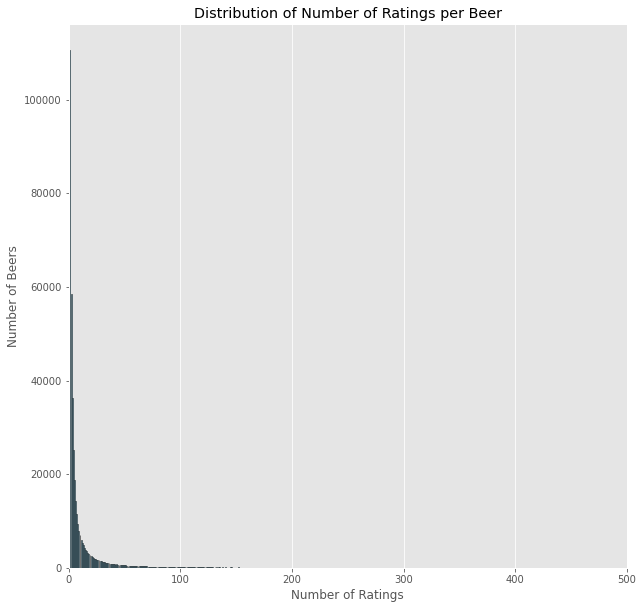

In [55]:
# Count the number of beers for each number of ratings
reviews_counts = df_beer['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Beers')
plt.title('Distribution of Number of Ratings per Beer')
plt.grid(axis='y')
plt.xlim(0, 500)
plt.show()


In [56]:
# Get an idea of the distribution of the number of ratings per beer

# Choose different quantile thresholds 
ratings_threshold75 = df_beer['nbr_ratings'].quantile(0.75)
ratings_threshold90 = df_beer['nbr_ratings'].quantile(0.90)
ratings_threshold95 = df_beer['nbr_ratings'].quantile(0.95)
ratings_threshold98 = df_beer['nbr_ratings'].quantile(0.98)
ratings_threshold99 = df_beer['nbr_ratings'].quantile(0.99)

# Filter beers based on the threshold
filtered_beers75 = df_beer[df_beer['nbr_ratings'] >= ratings_threshold75]
filtered_beers90 = df_beer[df_beer['nbr_ratings'] >= ratings_threshold90]
filtered_beers95 = df_beer[df_beer['nbr_ratings'] >= ratings_threshold95]
filtered_beers98 = df_beer[df_beer['nbr_ratings'] >= ratings_threshold98]
filtered_beers99 = df_beer[df_beer['nbr_ratings'] >= ratings_threshold99]

print(filtered_beers75.shape,
filtered_beers90.shape,
filtered_beers95.shape,
filtered_beers98.shape,
filtered_beers99.shape)

(103771, 13) (40441, 13) (19846, 13) (7964, 13) (3976, 13)


Note: we see that even by taking the top 1% of most rated beers (highest nbr_ratings) we still have 3976 beers. 

In [57]:
# Create a new DataFrame with beers in the 99th percentile
df_filtered_beer = filtered_beers99
display(df_filtered_beer)

,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,
3126,Tiger Beer,547,Singapore Brewery (Asia Pacific Breweries-Hein...,Pale Lager,1556,5.0,50.0,2.13,5.0,2.138560,NaN,0,NaN
51355,Lucky Beer (Lucky Buddha),11483,Cheerday Hangzhou Qiandaohu Beer Co.,Pale Lager,595,2.0,31.0,1.92,4.8,1.943361,NaN,0,NaN
17334,Harbin Beer,2951,Harbin Beer Company (AB InBev),Pale Lager,318,3.0,40.0,2.01,4.8,2.009119,NaN,0,NaN
730,Tsingtao,116,Tsingtao Brewery,Pale Lager,2031,3.0,42.0,2.03,4.8,2.045790,NaN,0,NaN
47351,Timișoreana,2300,Ursus Breweries (SABMiller),Pale Lager,290,6.0,69.0,2.26,5.0,2.285862,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2549,Zlatý Baant (12% / Golden Pheasant / Premium),443,Heineken Slovensko,Czech Pilsner (Světlý),904,15.0,29.0,2.68,5.0,2.685509,NaN,0,NaN
11012,Kenya Tusker Lager,1521,Kenya Breweries (EABL/East African Breweries -...,Pale Lager,1085,5.0,52.0,2.14,4.2,2.155115,NaN,0,NaN
17078,Leo Beer,178,Boon Rawd Brewery,Pale Lager,282,1.0,19.0,1.80,5.0,1.878369,NaN,0,NaN


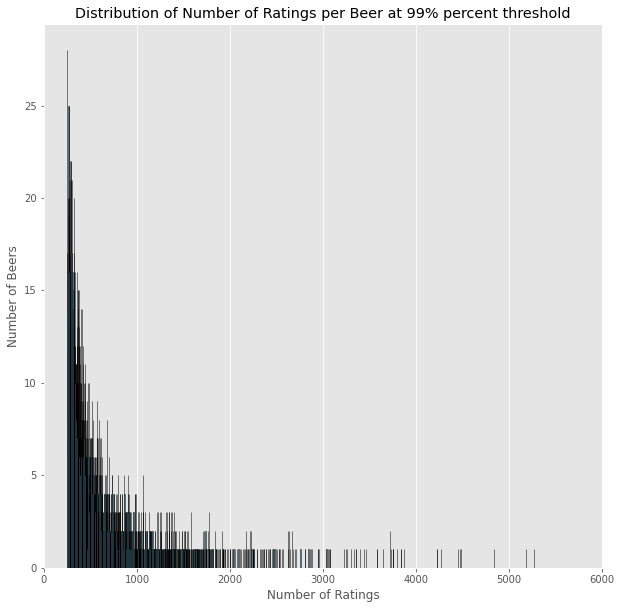

In [58]:
# Count the number of beers for each number of ratings
reviews_counts = df_filtered_beer['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Beers')
plt.title('Distribution of Number of Ratings per Beer at 99% percent threshold')
plt.grid(axis='y')
plt.xlim(0,6000)
plt.show()

In [59]:
display(df_beer['nbr_ratings'].describe())
display(df_filtered_beer['nbr_ratings'].describe())

count    396399.000000
mean         17.866168
std          84.688370
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max        5272.000000
Name: nbr_ratings, dtype: float64

count    3976.000000
mean      621.553068
std       532.415532
min       251.000000
25%       315.000000
50%       425.000000
75%       700.000000
max      5272.000000
Name: nbr_ratings, dtype: float64

Intepretation : 

In [60]:
# Display the most rated beer and the less rated one. 
display(df_filtered_beer.loc[df_filtered_beer['nbr_ratings'].idxmin()])
display(df_filtered_beer.loc[df_filtered_beer['nbr_ratings'].idxmax()])


beer_name                    Le Trou du Diable Sang-dEncre
brewery_id                                             6444
brewery_name                              Le Trou du Diable
style                                             Dry Stout
nbr_ratings                                             251
overall_score                                          87.0
style_score                                            96.0
avg                                                     3.5
abv                                                     5.5
avg_computed                                       3.509163
zscore                                                  NaN
nbr_matched_valid_ratings                                 0
avg_matched_valid_ratings                               NaN
Name: 54035, dtype: object

beer_name                    Rochefort Trappistes 10
brewery_id                                       406
brewery_name                     Brasserie Rochefort
style                                  Abt/Quadrupel
nbr_ratings                                     5272
overall_score                                  100.0
style_score                                    100.0
avg                                             4.29
abv                                             11.3
avg_computed                                4.319917
zscore                                      1.590864
nbr_matched_valid_ratings                       5270
avg_matched_valid_ratings                   4.320114
Name: 2360, dtype: object

Next we explore the zscore per beer, the basic descriptive statistics, it's distribution and some visualization. Will allow us later, when we recompute the new z-scores with the most active reviewer to compare them. 

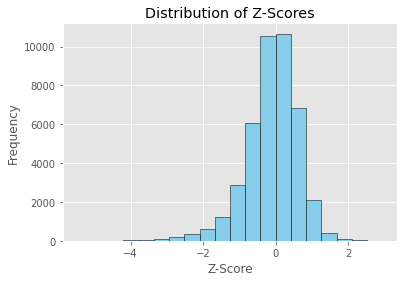

In [61]:
# Visualize the z-score distribution 

plt.hist(df_beer['zscore'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('Distribution of Z-Scores')
plt.show()

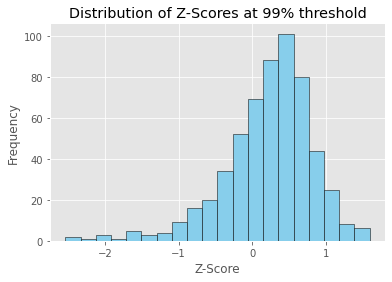

In [62]:
# Visualize the z-score distribution at 99% threshold 

plt.hist(df_filtered_beer['zscore'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('Distribution of Z-Scores at 99% threshold')
plt.show()

We can notice that for beers with nbr_ratings > 251 (the minimum number of ratings for the top 1% most rated beer) the z-score spreads less. 

In [63]:
display(df_beer['zscore'].describe())
display(df_filtered_beer['zscore'].describe())



count    42220.000000
mean        -0.104043
std          0.731610
min         -5.460346
25%         -0.479094
50%         -0.023696
75%          0.364636
max          2.941123
Name: zscore, dtype: float64

count    571.000000
mean       0.213717
std        0.607282
min       -2.535891
25%       -0.094813
50%        0.322966
75%        0.596215
max        1.590864
Name: zscore, dtype: float64

Intepretation : a mettre

Here we explore the overall_score per beer, the basic descriptive statistics, it's distribution and some visualization. 

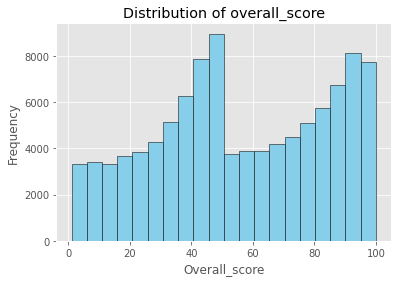

In [64]:
# Visualize the overall_score distribution 

plt.hist(df_beer['overall_score'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Overall_score')
plt.ylabel('Frequency')
plt.title('Distribution of overall_score')
plt.show()

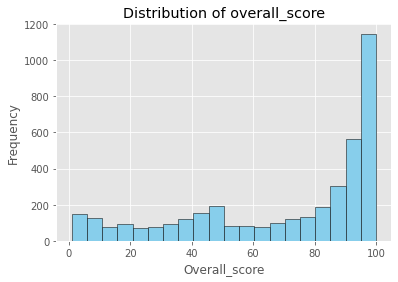

In [65]:
# Visualize the overall_score distribution at 99% threshold 

plt.hist(df_filtered_beer['overall_score'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Overall_score')
plt.ylabel('Frequency')
plt.title('Distribution of overall_score')
plt.show()

Note: The frequency of beers with low overall_score gets lower when having more ratings (as the second plot shows only the top 1% most rated beers). Shows that when we restrain the number of users --> ?

In [66]:
display(df_beer['overall_score'].describe())
display(df_filtered_beer['overall_score'].describe())

count    103737.000000
mean         55.837011
std          28.369274
min           1.000000
25%          35.000000
50%          53.000000
75%          83.000000
max         100.000000
Name: overall_score, dtype: float64

count    3961.000000
mean       70.686948
std        31.024802
min         1.000000
25%        47.000000
50%        86.000000
75%        96.000000
max       100.000000
Name: overall_score, dtype: float64

#### Data exploration on df_user

In [50]:
df_users.dropna(subset=['nbr_ratings'], inplace=True)
df_users

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain
2,169,288889,Sibarh,1.384600e+09,Poland
3,3371,250510,fombe89,1.363950e+09,Spain
4,13043,122778,kevnic2008,1.296644e+09,Germany
...,...,...,...,...,...
70169,1,134893,stamfordbus,1.315217e+09,England
70170,1,327816,fobia405,1.406282e+09,Belgium
70171,1,183139,junkin,1.339841e+09,NaN
70172,3,82020,klesidra,1.222250e+09,Slovenia


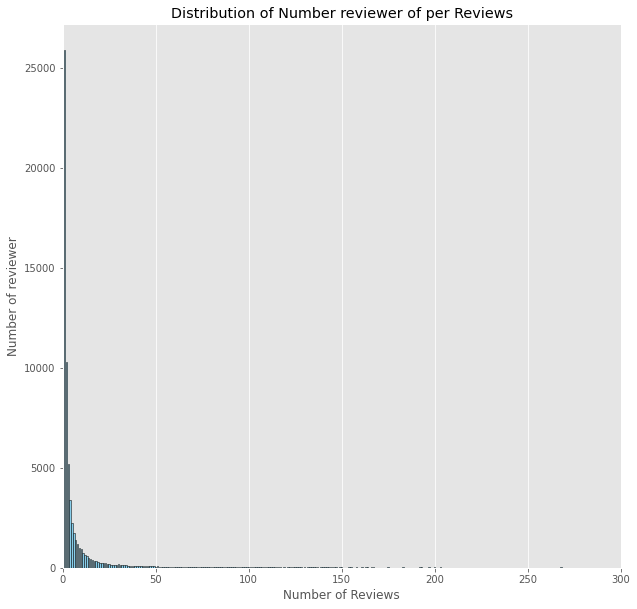

In [67]:
# Count the number of beers for each number of ratings
reviews_counts = df_users['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of reviewer')
plt.title('Distribution of Number reviewer of per Reviews')
plt.grid(axis='y')
plt.xlim(0,300)
plt.show()

In [68]:
# Choose a percentile threshold (adjust as needed)
ratings_threshold75 = df_users['nbr_ratings'].quantile(0.75)
ratings_threshold90 = df_users['nbr_ratings'].quantile(0.90)
ratings_threshold95 = df_users['nbr_ratings'].quantile(0.95)
ratings_threshold98 = df_users['nbr_ratings'].quantile(0.98)
ratings_threshold99 = df_users['nbr_ratings'].quantile(0.99)

# Filter beers based on the threshold
filtered_users75 = df_users[df_users['nbr_ratings'] >= ratings_threshold75]
filtered_users90 = df_users[df_users['nbr_ratings'] >= ratings_threshold90]
filtered_users95 = df_users[df_users['nbr_ratings'] >= ratings_threshold95]
filtered_users98 = df_users[df_users['nbr_ratings'] >= ratings_threshold98]
filtered_users99 = df_users[df_users['nbr_ratings'] >= ratings_threshold99]

print(filtered_users75.shape,
filtered_users90.shape,
filtered_users95.shape,
filtered_users98.shape,
filtered_users99.shape)

(17744, 5) (7037, 5) (3518, 5) (1404, 5) (702, 5)


702 users are in the top 1% of the most active users (thus the one having the highest nbr_ratings) 

In [69]:
# Create a new DataFrame with beers in the 99th percentile
df_filtered_users = filtered_users99
display(df_filtered_users)

,nbr_ratings,user_id,user_name,joined,location
3,3371,250510,fombe89,1.363950e+09,Spain
4,13043,122778,kevnic2008,1.296644e+09,Germany
5,21024,227834,Beerhunter111,1.352718e+09,Germany
6,8781,83106,Erzengel,1.224324e+09,Germany
7,4051,37316,Lowenbrau,1.147860e+09,Spain
...,...,...,...,...,...
8992,3038,114741,Reynolds314,1.286359e+09,"United States, Connecticut"
10064,2652,68527,baraciisch,1.201432e+09,"United States, California"
10567,5031,78749,BoBoChamp,1.216462e+09,Belgium
10772,2543,44516,islay,1.162552e+09,"United States, Minnesota"


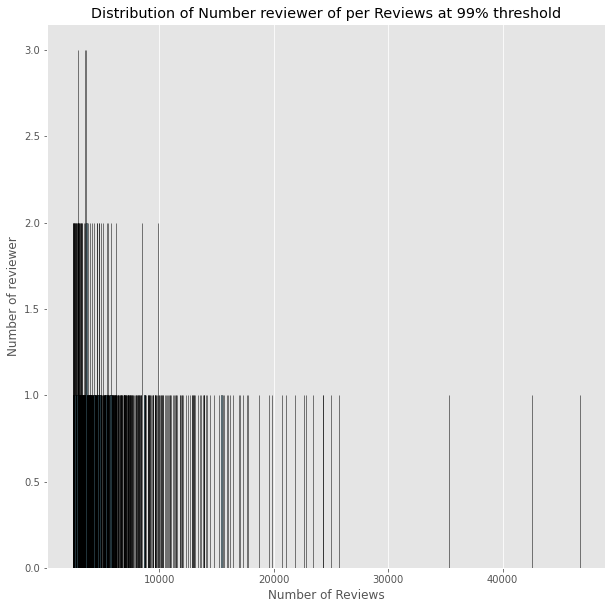

In [70]:
# Count the number of beers for each number of ratings
reviews_counts = df_filtered_users['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of reviewer')
plt.title('Distribution of Number reviewer of per Reviews at 99% threshold')
plt.grid(axis='y')
plt.show()

In [71]:
df_users['nbr_ratings'].describe()
df_filtered_users['nbr_ratings'].describe()

count      702.000000
mean      5761.478632
std       4497.338103
min       2406.000000
25%       3055.000000
50%       4298.500000
75%       6632.000000
max      46749.000000
Name: nbr_ratings, dtype: float64

In [72]:
display(df_filtered_users.loc[df_filtered_users['nbr_ratings'].idxmin()])
display(df_filtered_users.loc[df_filtered_users['nbr_ratings'].idxmax()])

nbr_ratings                       2406
user_id                         221043
user_name                     DCLawyer
joined                    1349431200.0
location       United States, Virginia
Name: 1754, dtype: object

nbr_ratings           46749
user_id               38926
user_name           fonefan
joined         1150970400.0
location            Denmark
Name: 16, dtype: object

Interpretation : --> ?

### BeerAdvocate website

In [73]:
df_beer_BA = pd.read_csv("BeerAdvocate/beers.csv", index_col='beer_id')
df_breweries_BA  = pd.read_csv("BeerAdvocate/breweries.csv")
df_users_BA = pd.read_csv("BEerAdvocate/users.csv")

In [75]:
df_beer_BA = df_beer_BA[df_beer_BA['nbr_ratings'] != 0].copy()
df_beer_BA = df_beer_BA[df_beer_BA['zscore'] != 0]
df_beer_BA = df_beer_BA[df_beer_BA['ba_score'] != 0]

In [76]:
df_beer_BA

,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,,
142544,Régab,37262,Societe des Brasseries du Gabon (SOBRAGA),Euro Pale Lager,1,1,2.88,NaN,NaN,4.5,2.880000,NaN,0,NaN
19590,Barelegs Brew,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,4,4,3.85,NaN,NaN,4.5,3.845000,NaN,0,NaN
19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,75,59,3.45,80.0,80.0,4.8,3.439867,-0.649167,59,3.504068
20841,St. Patrick's Ale,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,8,6,3.86,NaN,NaN,6.0,3.888750,0.093110,6,3.768333
20842,St. Patrick's Best,10093,Strangford Lough Brewing Company Ltd,English Bitter,64,48,3.56,82.0,90.0,4.2,3.556094,-0.478579,48,3.580417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19149,Diamond Stout,885,Summit Station Restaurant & Brewery,Irish Dry Stout,3,3,3.83,NaN,NaN,6.5,3.830000,NaN,0,NaN
19142,IPA,885,Summit Station Restaurant & Brewery,English India Pale Ale (IPA),2,2,3.24,NaN,NaN,5.6,3.240000,NaN,0,NaN
19141,Irvington Pale Ale,885,Summit Station Restaurant & Brewery,American Pale Ale (APA),3,3,3.60,NaN,NaN,6.8,3.596667,NaN,0,NaN


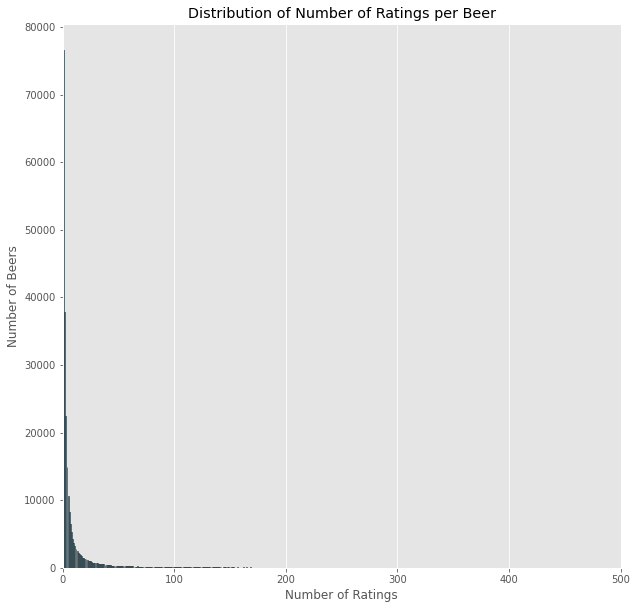

In [77]:
# Count the number of beers for each number of ratings
reviews_counts = df_beer_BA['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Beers')
plt.title('Distribution of Number of Ratings per Beer')
plt.grid(axis='y')
plt.xlim(0, 500)
plt.show()

In [78]:
# Get an idea of the distribution of the number of ratings per beer

# Choose different quantile thresholds 
ratings_threshold75_BA = df_beer_BA['nbr_ratings'].quantile(0.75)
ratings_threshold90_BA = df_beer_BA['nbr_ratings'].quantile(0.90)
ratings_threshold95_BA = df_beer_BA['nbr_ratings'].quantile(0.95)
ratings_threshold98_BA = df_beer_BA['nbr_ratings'].quantile(0.98)
ratings_threshold99_BA = df_beer_BA['nbr_ratings'].quantile(0.99)

# Filter beers based on the threshold
filtered_beers75_BA = df_beer_BA[df_beer_BA['nbr_ratings'] >= ratings_threshold75_BA]
filtered_beers90_BA = df_beer_BA[df_beer_BA['nbr_ratings'] >= ratings_threshold90_BA]
filtered_beers95_BA = df_beer_BA[df_beer_BA['nbr_ratings'] >= ratings_threshold95_BA]
filtered_beers98_BA = df_beer_BA[df_beer_BA['nbr_ratings'] >= ratings_threshold98_BA]
filtered_beers99_BA = df_beer_BA[df_beer_BA['nbr_ratings'] >= ratings_threshold99_BA]

print(filtered_beers75_BA.shape,
filtered_beers90_BA.shape,
filtered_beers95_BA.shape,
filtered_beers98_BA.shape,
filtered_beers99_BA.shape)

(65520, 14) (24828, 14) (12498, 14) (4975, 14) (2484, 14)


Note: we see that even by taking the top 1% of most rated beers we still have 2814 beers. If we compare this results to the one found in RateBeer, we have roughly 60% of the nbr_ratings for the top 1% rated beer.

In [79]:
# Create a new DataFrame with beers in the 99th percentile
df_filtered_beer_BA = filtered_beers99_BA
display(df_filtered_beer_BA)

,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,,
41037,Ola Dubh Special Reserve 12,323,Harviestoun Brewery Ltd.,Old Ale,834,383,4.13,92.0,NaN,8.0,4.114868,NaN,0,NaN
41012,Ola Dubh Special Reserve 16,323,Harviestoun Brewery Ltd.,Old Ale,628,297,4.12,91.0,NaN,8.0,4.126433,NaN,0,NaN
875,Old Engine Oil Black Ale,323,Harviestoun Brewery Ltd.,English Porter,1736,812,4.10,91.0,100.0,6.0,4.135737,NaN,0,NaN
12719,Innis And Gunn Original Oak Aged Beer,10272,Innis & Gunn,Scottish Ale,1775,571,3.75,85.0,81.0,6.6,3.740062,NaN,0,NaN
77595,Irish Whiskey Aged Scottish Stout,10272,Innis & Gunn,English Stout,672,177,3.81,86.0,NaN,7.4,3.818557,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49299,Baby Tree,18371,Pretty Things Beer & Ale Project,Quadrupel (Quad),819,351,3.86,87.0,NaN,9.0,3.907070,NaN,0,NaN
57088,Fluffy White Rabbits,18371,Pretty Things Beer & Ale Project,Tripel,630,187,4.03,90.0,NaN,8.5,4.019238,NaN,0,NaN
46290,Jack D'Or,18371,Pretty Things Beer & Ale Project,Saison / Farmhouse Ale,1640,642,4.01,90.0,96.0,6.5,4.036098,NaN,0,NaN


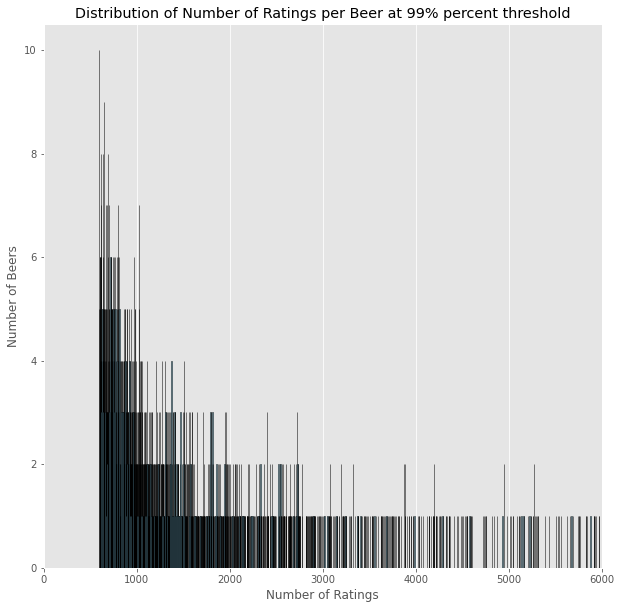

In [80]:
# Count the number of beers for each number of ratings
reviews_counts = df_filtered_beer_BA['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Beers')
plt.title('Distribution of Number of Ratings per Beer at 99% percent threshold')
plt.grid(axis='y')
plt.xlim(0,6000)
plt.show()

In [82]:
display(df_beer_BA['nbr_ratings'].describe(),
df_filtered_beer_BA['nbr_ratings'].describe())

count    247982.000000
mean         33.845327
std         245.558727
min           1.000000
25%           1.000000
50%           3.000000
75%           9.000000
max       16509.000000
Name: nbr_ratings, dtype: float64

count     2484.000000
mean      1725.489533
std       1695.017056
min        597.000000
25%        784.000000
50%       1111.000000
75%       1930.250000
max      16509.000000
Name: nbr_ratings, dtype: float64

In [84]:
display(df_filtered_beer_BA.loc[df_filtered_beer_BA['nbr_ratings'].idxmin()])
display(df_filtered_beer_BA.loc[df_filtered_beer_BA['nbr_ratings'].idxmax()])

beer_name                          Snapperhead IPA
brewery_id                                   13302
brewery_name                 Butternuts Beer & Ale
style                                 American IPA
nbr_ratings                                    597
nbr_reviews                                    312
avg                                           3.16
ba_score                                      74.0
bros_score                                     NaN
abv                                            6.8
avg_computed                              3.092982
zscore                                   -1.319106
nbr_matched_valid_ratings                      318
avg_matched_valid_ratings                 3.184182
Name: 34968, dtype: object

beer_name                            Founders Breakfast Stout
brewery_id                                               1199
brewery_name                         Founders Brewing Company
style                        American Double / Imperial Stout
nbr_ratings                                             16509
nbr_reviews                                              3811
avg                                                      4.47
ba_score                                                 99.0
bros_score                                              100.0
abv                                                       8.3
avg_computed                                          4.51376
zscore                                                    NaN
nbr_matched_valid_ratings                                   0
avg_matched_valid_ratings                                 NaN
Name: 11757, dtype: object

Gives us an idea of the distribution of the most rated beers (nbr_ratings) and the maximum/minimum nbr_ratings of the top 1% most rated beer. Despite having less beer in the top 1% than in RateBeer they have more ratings (minimum 597 here vs 251 in RateBeer). 

Next we explore the zscore per beer, the basic descriptive statistics, it's distribution and some visualization. Will allow us later, when we recompute the new z-scores with the most active reviewer to compare them. 

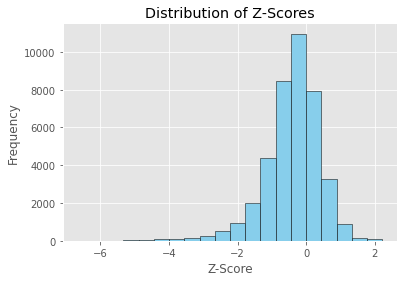

In [85]:
# Visualize the z-score distribution 

plt.hist(df_beer_BA['zscore'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('Distribution of Z-Scores')
plt.show()

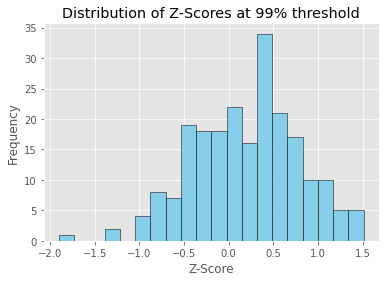

In [86]:
# Visualize the z-score distribution at 99% threshold 

plt.hist(df_filtered_beer_BA['zscore'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('Distribution of Z-Scores at 99% threshold')
plt.show()

We can notice that for beers with nbr_ratings > 597 (the minimum number of ratings for the top 1% most rated beer) the z-score spreads less (and more than for RateBeer as we have more nbr_ratings per beer). 

In [87]:
display(df_beer_BA['zscore'].describe(),
df_filtered_beer_BA['zscore'].describe())

count    40285.000000
mean        -0.408295
std          0.806491
min         -6.655704
25%         -0.785424
50%         -0.321596
75%          0.086733
max          2.211576
Name: zscore, dtype: float64

count    217.000000
mean       0.197055
std        0.589858
min       -1.898775
25%       -0.237856
50%        0.249774
75%        0.608517
max        1.510870
Name: zscore, dtype: float64

interpretation : --> ?

Here we explore the ba_score per beer, the basic descriptive statistics, it's distribution and some visualization. 

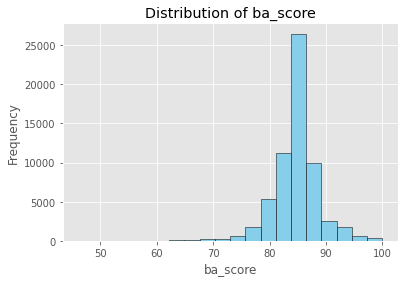

In [88]:
# Visualize the z-score distribution 

plt.hist(df_beer_BA['ba_score'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('ba_score')
plt.ylabel('Frequency')
plt.title('Distribution of ba_score')
plt.show()

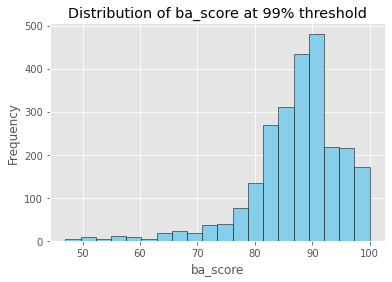

In [89]:
# Visualize the z-score distribution at 99% threshold 

plt.hist(df_filtered_beer_BA['ba_score'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('ba_score')
plt.ylabel('Frequency')
plt.title('Distribution of ba_score at 99% threshold')
plt.show()

Note: The mean ba_score of beers shifts to the right when having more ratings (as the second plot shows only the top 1% most rated beers). Shows that when we restrain the number of users... --> ?

In [90]:
display(df_beer_BA['ba_score'].describe(),
df_filtered_beer_BA['ba_score'].describe())

count    61199.000000
mean        84.633278
std          4.052756
min         46.000000
25%         83.000000
50%         85.000000
75%         86.000000
max        100.000000
Name: ba_score, dtype: float64

count    2484.000000
mean       87.398148
std         7.960010
min        47.000000
25%        84.000000
50%        88.000000
75%        92.000000
max       100.000000
Name: ba_score, dtype: float64

Intepretation : --> ?

### Data exploration on df_user_BA

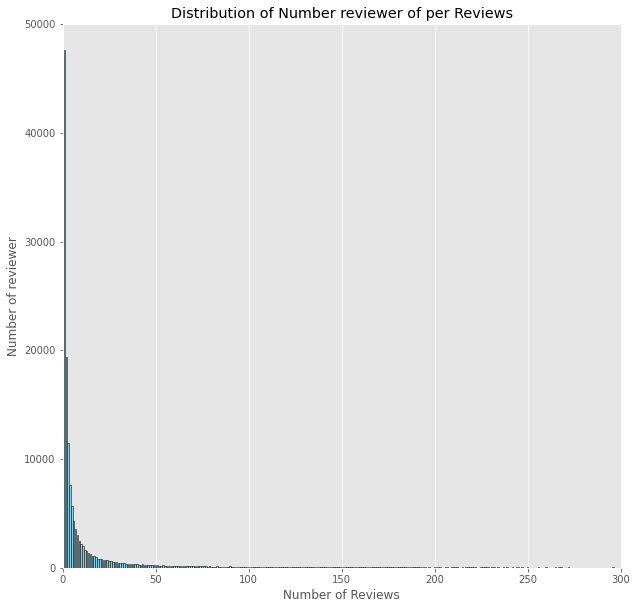

In [91]:
# Count the number of beers for each number of ratings
reviews_counts = df_users_BA['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of reviewer')
plt.title('Distribution of Number reviewer of per Reviews')
plt.grid(axis='y')
plt.xlim(0,300)
plt.show()

In [92]:
# Get an idea of the distribution of the number of ratings per beer

# Choose different quantile thresholds 
ratings_threshold75_BA = df_users_BA['nbr_ratings'].quantile(0.75)
ratings_threshold90_BA = df_users_BA['nbr_ratings'].quantile(0.90)
ratings_threshold95_BA = df_users_BA['nbr_ratings'].quantile(0.95)
ratings_threshold98_BA = df_users_BA['nbr_ratings'].quantile(0.98)
ratings_threshold99_BA = df_users_BA['nbr_ratings'].quantile(0.99)

# Filter beers based on the threshold
filtered_users75_BA = df_users_BA[df_users_BA['nbr_ratings'] >= ratings_threshold75_BA]
filtered_users90_BA = df_users_BA[df_users_BA['nbr_ratings'] >= ratings_threshold90_BA]
filtered_users95_BA = df_users_BA[df_users_BA['nbr_ratings'] >= ratings_threshold95_BA]
filtered_users98_BA = df_users_BA[df_users_BA['nbr_ratings'] >= ratings_threshold98_BA]
filtered_users99_BA = df_users_BA[df_users_BA['nbr_ratings'] >= ratings_threshold99_BA]

print(filtered_beers75_BA.shape,
filtered_users90_BA.shape,
filtered_users95_BA.shape,
filtered_users98_BA.shape,
filtered_users99_BA.shape)

(65520, 14) (15415, 6) (7708, 6) (3075, 6) (1542, 6)


We have 1542 users at the top 1% of nbr_ratings. 

In [93]:
# Create a new DataFrame with beers in the 99th percentile
df_filtered_users_BA = filtered_users99_BA
display(df_filtered_users_BA)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
5,2326,0,hellpop65.48993,Hellpop65,1.131966e+09,"United States, Kansas"
6,3098,0,latarnik.52897,Latarnik,1.133521e+09,"United States, New Jersey"
...,...,...,...,...,...,...
30610,1331,0,italianstallion.788089,italianstallion,1.394622e+09,"United States, Wisconsin"
32690,1261,1017,ri0.683063,Ri0,1.341137e+09,"United States, Wisconsin"
32760,1219,5,xdtfx.691499,xdtfx,1.346062e+09,"United States, Illinois"
40813,1039,542,mikeward.620428,MikeWard,1.315994e+09,"United States, Pennsylvania"


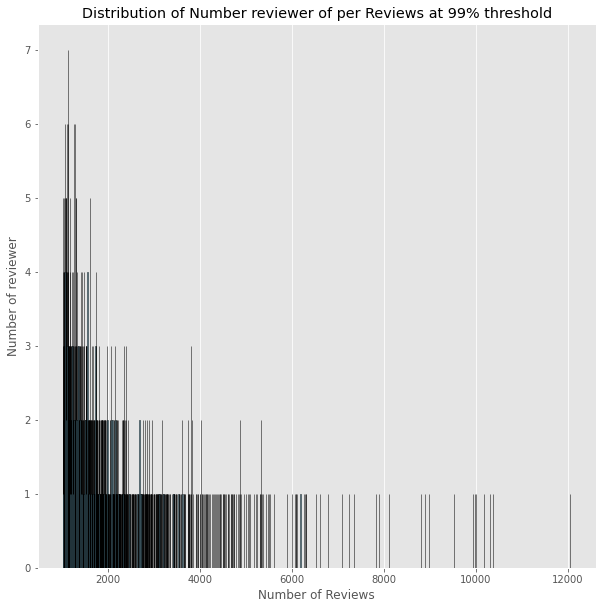

In [94]:
# Count the number of beers for each number of ratings
reviews_counts = df_filtered_users_BA['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of reviewer')
plt.title('Distribution of Number reviewer of per Reviews at 99% threshold')
plt.grid(axis='y')
plt.show()

In [96]:
display(df_users_BA['nbr_ratings'].describe(),
df_filtered_users_BA['nbr_ratings'].describe())


count    153704.000000
mean         54.605163
std         252.388790
min           1.000000
25%           1.000000
50%           3.000000
75%          16.000000
max       12046.000000
Name: nbr_ratings, dtype: float64

count     1542.000000
mean      1965.327497
std       1250.713955
min       1023.000000
25%       1221.000000
50%       1538.000000
75%       2186.250000
max      12046.000000
Name: nbr_ratings, dtype: float64

In [95]:
display(df_filtered_users_BA.loc[df_filtered_users_BA['nbr_ratings'].idxmax()],
df_filtered_users_BA.loc[df_filtered_users_BA['nbr_ratings'].idxmin()])

nbr_ratings           12046
nbr_reviews            7593
user_id          sammy.3853
user_name             Sammy
joined         1070276400.0
location             Canada
Name: 228, dtype: object

nbr_ratings                       1023
nbr_reviews                         71
user_id             stampfler07.154141
user_name                  stampfler07
joined                    1187604000.0
location       United States, Colorado
Name: 586, dtype: object

#### MatchedBeer data

Here we show that we can not work with the Matched_beer data frames as they only take into account the users with ratings of BeerAdvocate and RateBeer, thus we ommit a significative part of the most active users in each site. 

In [97]:
pd.set_option('display.max_columns', None)
df_users_matched = pd.read_csv("matched_beer_data/users.csv", header=1)
df_users_matched

,joined,location,nbr_ratings,nbr_reviews,user_id,user_name,user_name_lower,joined.1,location.1,nbr_ratings.1,user_id.1,user_name.1,user_name_lower.1
0,1.220868e+09,Germany,6,6,erzengel.248045,Erzengel,erzengel,1.224324e+09,Germany,8781,83106,Erzengel,erzengel
1,1.348394e+09,"United States, Virginia",1,1,gendv138.695700,GenDV138,gendv138,1.385723e+09,"United States, Virginia",6240,290599,GenDV138,gendv138
2,1.207303e+09,"United States, Washington",3,3,nimbleprop.208928,nimbleprop,nimbleprop,1.150798e+09,"United States, Washington",7452,38859,nimbleprop,nimbleprop
3,1.322737e+09,Estonia,11,0,visionthing.639993,visionthing,visionthing,1.242986e+09,Estonia,5462,91324,visionthing,visionthing
4,1.432116e+09,England,1,0,lazypyro.989356,LazyPyro,lazypyro,1.431166e+09,England,1096,368991,LazyPyro,lazypyro
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3015,1.253182e+09,"United States, Pennsylvania",398,398,shadesofgray.371155,ShadesOfGray,shadesofgray,1.261998e+09,"United States, Pennsylvania",1,99346,ShadesOfGray,shadesofgray
3016,1.095847e+09,"United States, Michigan",587,587,ypsifly.8833,ypsifly,ypsifly,1.139569e+09,"United States, Michigan",1,33393,ypsifly,ypsifly
3017,1.047121e+09,"United States, Texas",1379,1379,hardtarget.1712,HardTarget,hardtarget,1.095934e+09,"United States, Texas",1,15553,HardTarget,hardtarget
3018,1.416740e+09,Vietnam,176,24,nelsonsaigon.897449,nelsonsaigon,nelsonsaigon,1.406369e+09,Vietnam,1,327965,nelsonsaigon,nelsonsaigon


In [99]:
# Only taking the part of the data frame which comes from RateBeer 
df_users_matched = df_users_matched.loc[:, 'location.1':'user_name_lower.1']
df_users_matched.dropna(subset=['nbr_ratings.1'], inplace=True)
df_users_matched

,location.1,nbr_ratings.1,user_id.1,user_name.1,user_name_lower.1
0,Germany,8781,83106,Erzengel,erzengel
1,"United States, Virginia",6240,290599,GenDV138,gendv138
2,"United States, Washington",7452,38859,nimbleprop,nimbleprop
3,Estonia,5462,91324,visionthing,visionthing
4,England,1096,368991,LazyPyro,lazypyro
...,...,...,...,...,...
3015,"United States, Pennsylvania",1,99346,ShadesOfGray,shadesofgray
3016,"United States, Michigan",1,33393,ypsifly,ypsifly
3017,"United States, Texas",1,15553,HardTarget,hardtarget
3018,Vietnam,1,327965,nelsonsaigon,nelsonsaigon


In [100]:
ratings_threshold99_matched = df_users_matched['nbr_ratings.1'].quantile(0.99)
filtered_users99_matched = df_users_matched[df_users_matched['nbr_ratings.1'] >= ratings_threshold99_matched]

filtered_users99_matched.shape

(31, 5)

In [101]:
display(filtered_users99_matched.loc[filtered_users99_matched['nbr_ratings.1'].idxmax()],
        filtered_users99_matched.loc[filtered_users99_matched['nbr_ratings.1'].idxmin()])

location.1                  Germany
nbr_ratings.1                 20678
user_id.1                     17095
user_name.1          Koelschtrinker
user_name_lower.1    koelschtrinker
Name: 8, dtype: object

location.1           Netherlands
nbr_ratings.1               5733
user_id.1                 285335
user_name.1               Maakun
user_name_lower.1         maakun
Name: 67, dtype: object

In [102]:
print(df_filtered_users[df_filtered_users['user_id'] == 17095])


     nbr_ratings  user_id       user_name        joined location
101        20678    17095  Koelschtrinker  1.100257e+09  Germany


In [103]:
df_filtered_users_ranked = df_filtered_users.sort_values('nbr_ratings', ascending=False)
df_filtered_users_ranked

,nbr_ratings,user_id,user_name,joined,location
16,46749,38926,fonefan,1.150970e+09,Denmark
54,42567,30149,yespr,1.132398e+09,Denmark
161,35316,5328,Ungstrup,1.028714e+09,Denmark
140,25701,14280,joergen,1.091786e+09,Denmark
27,24966,19328,oh6gdx,1.106737e+09,Finland
...,...,...,...,...,...
200,2409,266560,vinivini,1.372586e+09,Belarus
2107,2409,91686,DeanF,1.243850e+09,Canada
848,2407,3847,jazz88,1.016968e+09,"United States, California"
3441,2407,203936,Cool_Bond,1.342087e+09,Sweden


In [104]:
rank = df_filtered_users_ranked[df_filtered_users_ranked['user_id'] == 17095].index[0] + 1
print("Rank of user with user_id 17095:", rank)

Rank of user with user_id 17095: 102


En gros le user le plus actif dans le fichier matched beer (users.csv) sur le site RateBeer est que 102 dans les users uniquement dans RateBeer. Donc utiliser
la matched data frame sur les users c'est pas le bon choix.

*ALL OF THE FEATURES USED TO BUILD THE TRIPS*


|Name | Object  | Description   |
| -------- | -------- | -------- |
| *df_beer_breweries_clean* | DataFrame | filtered dataset with both beer and breweries data|
|  abv  | Series - float  | Indicates the beer's alcohol percentage|
|  avg  | Series - float  | Average score given to the beer |
|  avg_computed -float | Series - float  ||
|  avg_matched_valid_ratings | Series - float  ||
|  ba_score  | Series - float  ||
|  beer_id  | Series - int  | Unique ID of each beer|
|  beer_name  | Series - string  | Name of the beer |
|  brewery_id  | Series - int  | Unique ID for each brewery the beers belong to|
|  brewery_name  | Series - string  | Name of the brewery|
|    | Series   ||
|    | Series   ||
|    | Series   ||
|    | Series   ||
|    | Series   ||
|    | Series   ||
|    | Series   ||

### Start to build our different trips :

**BREWERIES PER KM2**

location
Argentina                   2780400.0
Australia                   7692024.0
Austria                       83871.0
Belgium                       30689.0
Brazil                      8515767.0
                              ...    
United States, Wisconsin     169635.0
United States, Wyoming       253335.0
Uzbekistan                   448978.0
Vietnam                      331212.0
Wales                         20779.0
Name: km2, Length: 111, dtype: float64

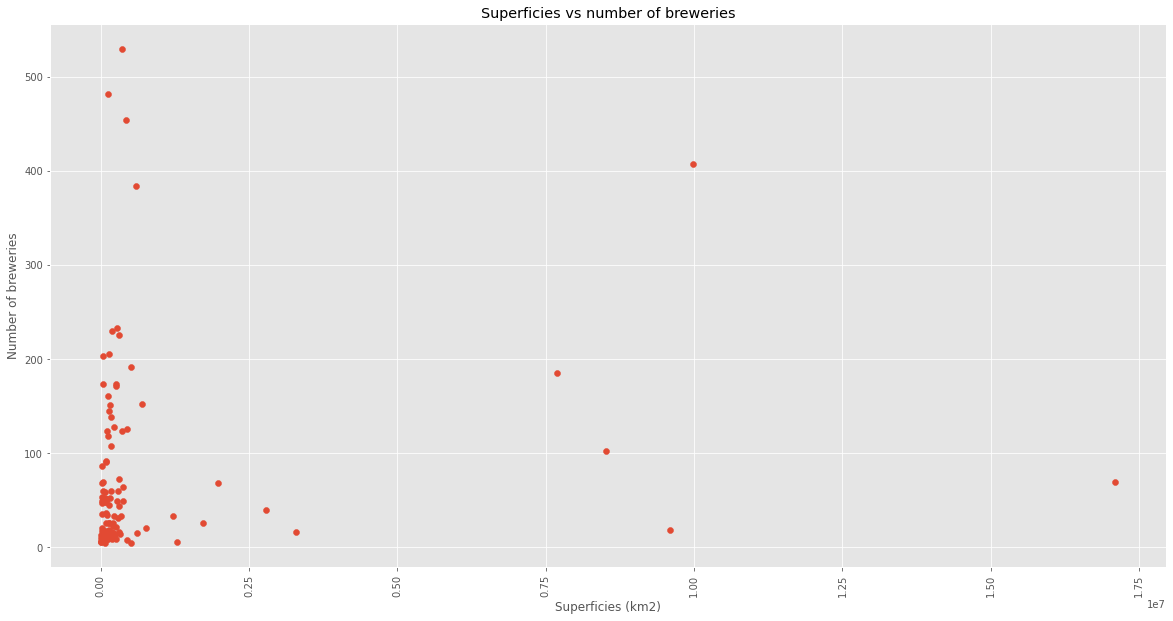

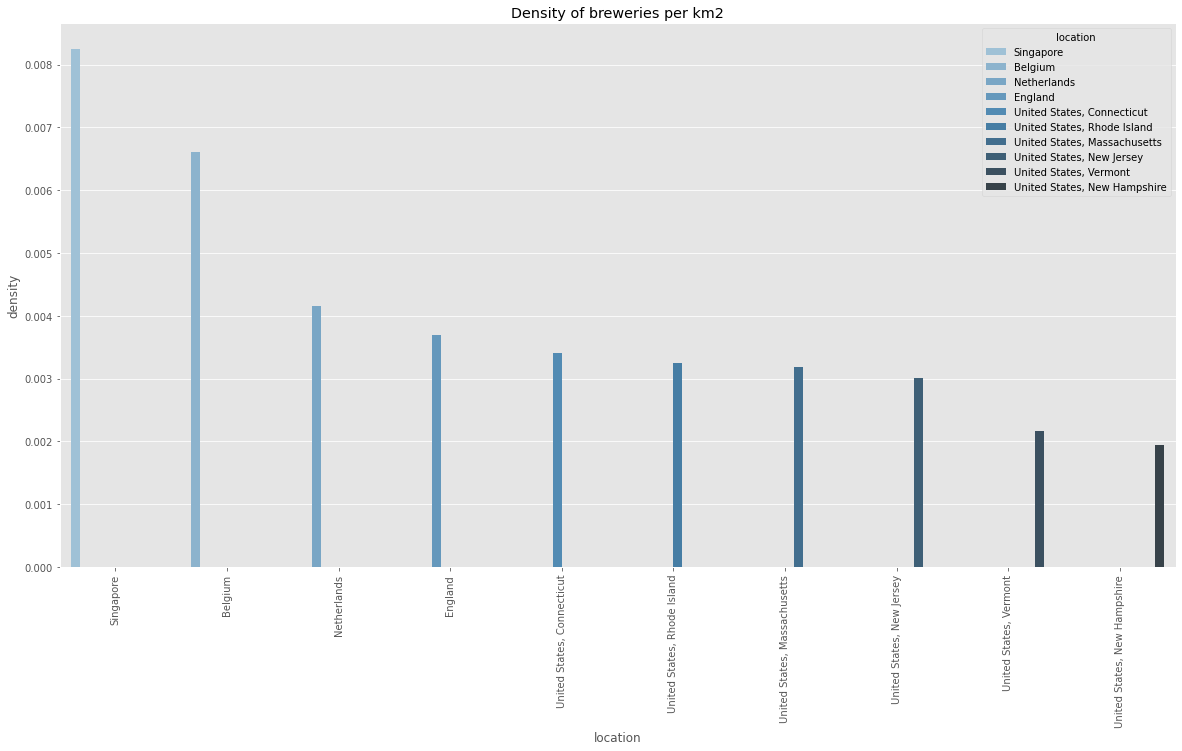

In [12]:
#Group the breweries by country, count the number of breweries and divide by the superfices of the location to have a density :
df_breweries_superficies_count = df_breweries_superficies_flt.groupby(['location']).id.count()
#display(df_breweries_superficies_flt)

#Get the values of the km2 in every location 
df_breweries_superficies_km2 = df_breweries_superficies_flt.groupby(['location']).km2.mean()
display(df_breweries_superficies_km2)

#Plot with superficies vs number of breweries
plt.figure(figsize=(20,10))
plt.scatter(df_breweries_superficies_km2, df_breweries_superficies_count)
plt.xlabel('Superficies (km2)')
plt.ylabel('Number of breweries')
plt.xticks(rotation=90)
plt.title('Superficies vs number of breweries')
plt.show()

#Concatenate the two dataframe to have access to the density of breweries per km2
df_density = pd.concat([df_breweries_superficies_count, df_breweries_superficies_km2], axis=1)
df_density['density'] = df_density['id'] / df_density['km2']
df_density.reset_index(inplace=True)
df_density.sort_values(by=['density'], ascending=False, inplace=True) 
top_ten_density = df_density.head(10)

#Plot the density of breweries per km2
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.title('Density of breweries per km2')
sns.barplot(x='location', y='density', data=top_ten_density, palette='Blues_d', hue='location')
plt.show()

#Store the location of the top 10 density of breweries per km2
top_ten_density_location = top_ten_density['location']

#NO error bar because we don't have the standard deviation of the density of breweries per km2....



**THE PERCENTAGE OF ALCOHOL**

In [13]:
#Drop the location with less than 5 beers (to do a beer trip, we need to have different beer to drink!) and beer with less than 20 ratings
df_beer_breweries_flt_abv = df_beer_breweries_clean.groupby('location').filter(lambda x: (len(x) >= 5) | (x['nbr_ratings'].sum() + x['nbr_ratings.1'].sum() >= 20)) 


,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Trinidad & Tobago,8.0,3.525000,1.971765,1.2,1.200,4.45,5.050,5.5
Bosnia and Herzegovina,3.0,3.666667,1.457166,2.0,3.150,4.30,4.500,4.7
Albania,1.0,4.100000,NaN,4.1,4.100,4.10,4.100,4.1
Jersey,5.0,4.100000,0.264575,3.7,4.000,4.20,4.200,4.4
Cuba,2.0,4.250000,0.353553,4.0,4.125,4.25,4.375,4.5
Lebanon,2.0,4.350000,2.333452,2.7,3.525,4.35,5.175,6.0
Malawi,3.0,4.466667,1.078579,3.7,3.850,4.00,4.850,5.7
Uzbekistan,12.0,4.475000,0.601702,3.4,4.225,4.40,5.000,5.4
Isle of Man,4.0,4.650000,1.297433,3.7,3.775,4.20,5.075,6.5


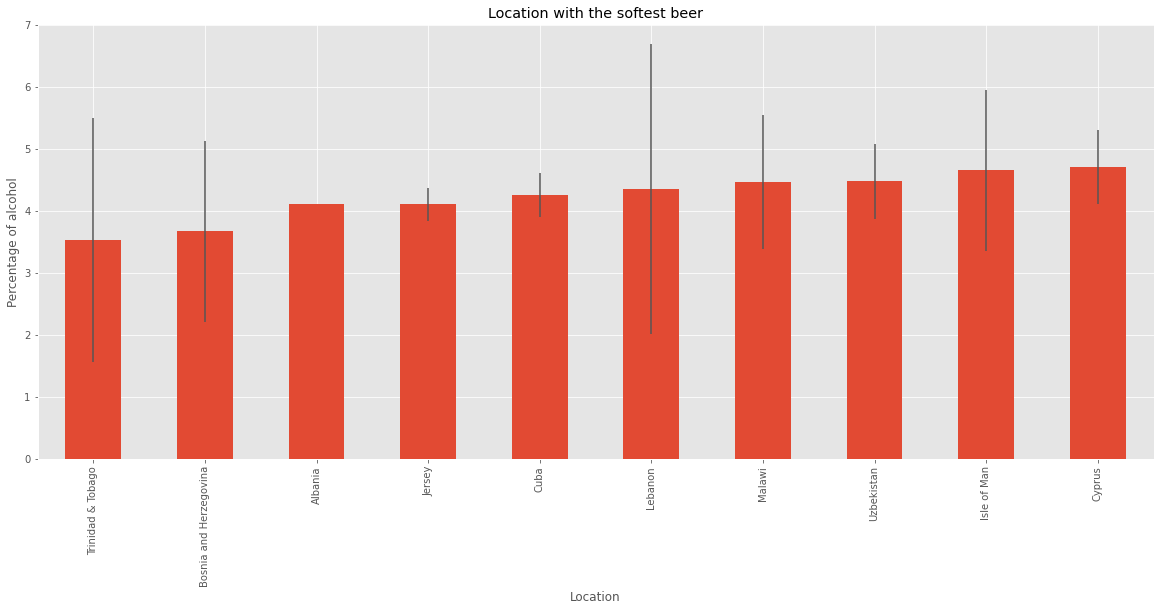

In [14]:
#Sort the dataframe by considering the 10 location with the softest beer
avg_rating_location = df_beer_breweries_flt_abv.groupby('location').abv.describe()
avg_rating_location.sort_values(by='mean', ascending=True, inplace=True)
top_ten_abv_soft = avg_rating_location.head(10)
display(top_ten_abv_soft)

#Plot the result with standard deviation as error bar
pl = top_ten_abv_soft['mean'].plot(kind='bar', figsize=[20,8], rot=0, yerr=top_ten_abv_soft['std']) #mieux de faire avec CI ?????
pl.set_title('Location with the softest beer')
pl.set_ylabel('Percentage of alcohol')
pl.set_xlabel('Location')
pl.set_xticklabels(top_ten_abv_soft.index, rotation=90)


#Keep a copy the ranking 
top_ten_abv_only_location = top_ten_abv_soft.index 


,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Egypt,4.0,7.675000,2.736634,4.7,5.675,8.00,10.000,10.0
Estonia,69.0,7.482609,2.704080,3.8,5.500,6.90,8.900,16.0
Belgium,863.0,7.115435,2.328768,0.5,6.000,7.00,8.000,39.0
Iceland,45.0,7.108889,2.644619,4.0,5.200,6.00,9.000,14.5
"United States, Rhode Island",143.0,7.013566,2.198081,2.5,5.500,6.60,8.000,12.5
Netherlands,569.0,7.005290,2.022058,0.5,5.600,6.60,8.200,20.0
"United States, Oklahoma",90.0,6.880000,2.655933,3.7,5.075,6.25,8.000,17.0
"United States, Georgia",461.0,6.852278,1.906642,3.0,5.300,6.50,8.100,13.9
Mauritius,12.0,6.825000,2.100271,4.8,5.600,6.20,7.375,12.0


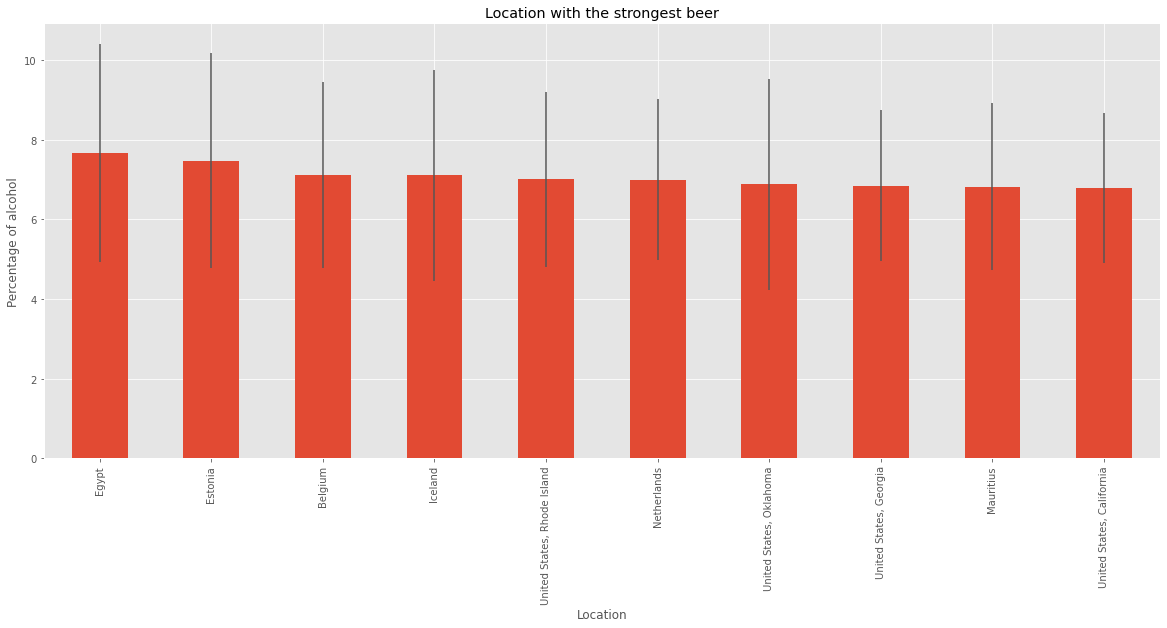

In [15]:
#Sort the dataframe by considering the 10 location with the strongest beer
avg_rating_location = df_beer_breweries_flt_abv.groupby('location').abv.describe()
avg_rating_location.sort_values(by='mean', ascending=False, inplace=True)
top_ten_abv_strong = avg_rating_location.head(10)
display(top_ten_abv_strong)

#Plot the result with standard deviation as error bar
pl = top_ten_abv_strong['mean'].plot(kind='bar', figsize=[20,8], rot=0, yerr=top_ten_abv_strong['std']) #mieux de faire avec CI ?????
pl.set_title('Location with the strongest beer')
pl.set_ylabel('Percentage of alcohol')
pl.set_xlabel('Location')
pl.set_xticklabels(top_ten_abv_strong.index, rotation=90)

#Keep a copy the ranking 
top_ten_abv_only_location = top_ten_abv_strong.index 


**THE RATINGS IN GLOBAL**

(162, 30)


[Text(0, 0, 'Albania'),
 Text(1, 0, 'Algeria'),
 Text(2, 0, 'Angola'),
 Text(3, 0, 'Argentina'),
 Text(4, 0, 'Australia'),
 Text(5, 0, 'Austria'),
 Text(6, 0, 'Bahamas'),
 Text(7, 0, 'Belarus'),
 Text(8, 0, 'Belgium'),
 Text(9, 0, 'Bhutan'),
 Text(10, 0, 'Bosnia and Herzegovina'),
 Text(11, 0, 'Brazil'),
 Text(12, 0, 'Bulgaria'),
 Text(13, 0, 'Cambodia'),
 Text(14, 0, 'Cameroon'),
 Text(15, 0, 'Canada'),
 Text(16, 0, 'Cape Verde Islands'),
 Text(17, 0, 'Cayman Islands'),
 Text(18, 0, 'Chile'),
 Text(19, 0, 'China'),
 Text(20, 0, 'Colombia'),
 Text(21, 0, 'Cook Islands'),
 Text(22, 0, 'Costa Rica'),
 Text(23, 0, 'Croatia'),
 Text(24, 0, 'Cuba'),
 Text(25, 0, 'Cyprus'),
 Text(26, 0, 'Czech Republic'),
 Text(27, 0, 'Denmark'),
 Text(28, 0, 'Egypt'),
 Text(29, 0, 'El Salvador'),
 Text(30, 0, 'England'),
 Text(31, 0, 'Eritrea'),
 Text(32, 0, 'Estonia'),
 Text(33, 0, 'Faroe Islands'),
 Text(34, 0, 'Finland'),
 Text(35, 0, 'France'),
 Text(36, 0, 'French Polynesia'),
 Text(37, 0, 'Georgia'),


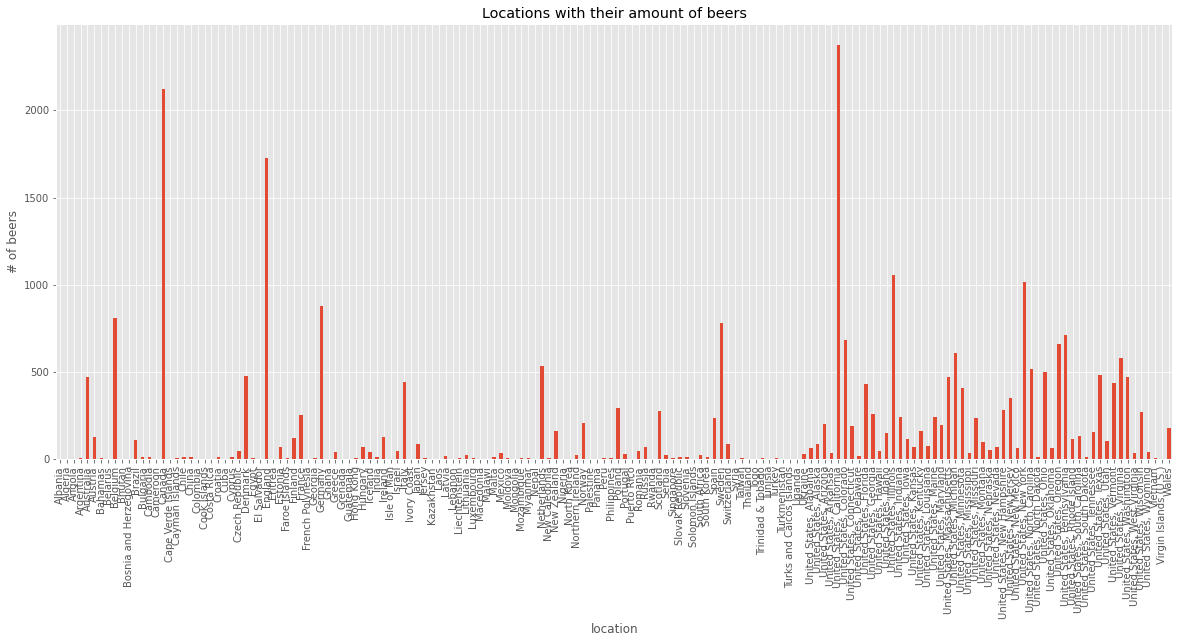

In [16]:
#Select only the beers with at least 5 ratings on either sites (RateBeer and Beer Advocate), because we want to have a good idea of the quality of the beers: 
df_beer_breweries_clean_5_plus = df_beer_breweries_clean[(df_beer_breweries_clean['nbr_ratings'] >=5) | (df_beer_breweries_clean['nbr_ratings.1'] >=5)]

#Grouped the beers by location and count the number of beers in each location
df_beer_breweries_clean_5_plus_4plot = df_beer_breweries_clean_5_plus.groupby(['location']).count()
print(df_beer_breweries_clean_5_plus_4plot.shape)

#Plot the location with the most beers with at least 5 ratings on each sites
pl = df_beer_breweries_clean_5_plus_4plot['beer_name'].plot(kind='bar', figsize=[20,8])
pl.set_title('Locations with their amount of beers')
pl.set_ylabel('# of beers')
pl.set_xlabel('location')
pl.set_xticklabels(df_beer_breweries_clean_5_plus_4plot.index, rotation=90)


We can see on the previous graph that we still have a lot of location to visit after keeping only the beers with more than 5 ratings on both websites, but we can restrain even more this number by imposing conditions on the minimum amount of beers in a location to be considered as a potential destination for the trip. 

[Text(0, 0, 'Albania'),
 Text(1, 0, 'Algeria'),
 Text(2, 0, 'Angola'),
 Text(3, 0, 'Argentina'),
 Text(4, 0, 'Australia'),
 Text(5, 0, 'Austria'),
 Text(6, 0, 'Bahamas'),
 Text(7, 0, 'Belarus'),
 Text(8, 0, 'Belgium'),
 Text(9, 0, 'Bhutan'),
 Text(10, 0, 'Bosnia and Herzegovina'),
 Text(11, 0, 'Brazil'),
 Text(12, 0, 'Bulgaria'),
 Text(13, 0, 'Cambodia'),
 Text(14, 0, 'Cameroon'),
 Text(15, 0, 'Canada'),
 Text(16, 0, 'Cape Verde Islands'),
 Text(17, 0, 'Cayman Islands'),
 Text(18, 0, 'Chile'),
 Text(19, 0, 'China'),
 Text(20, 0, 'Colombia'),
 Text(21, 0, 'Cook Islands'),
 Text(22, 0, 'Costa Rica'),
 Text(23, 0, 'Croatia'),
 Text(24, 0, 'Cuba'),
 Text(25, 0, 'Cyprus'),
 Text(26, 0, 'Czech Republic'),
 Text(27, 0, 'Denmark'),
 Text(28, 0, 'Egypt'),
 Text(29, 0, 'El Salvador'),
 Text(30, 0, 'England'),
 Text(31, 0, 'Eritrea'),
 Text(32, 0, 'Estonia'),
 Text(33, 0, 'Faroe Islands'),
 Text(34, 0, 'Finland'),
 Text(35, 0, 'France'),
 Text(36, 0, 'French Polynesia'),
 Text(37, 0, 'Georgia'),


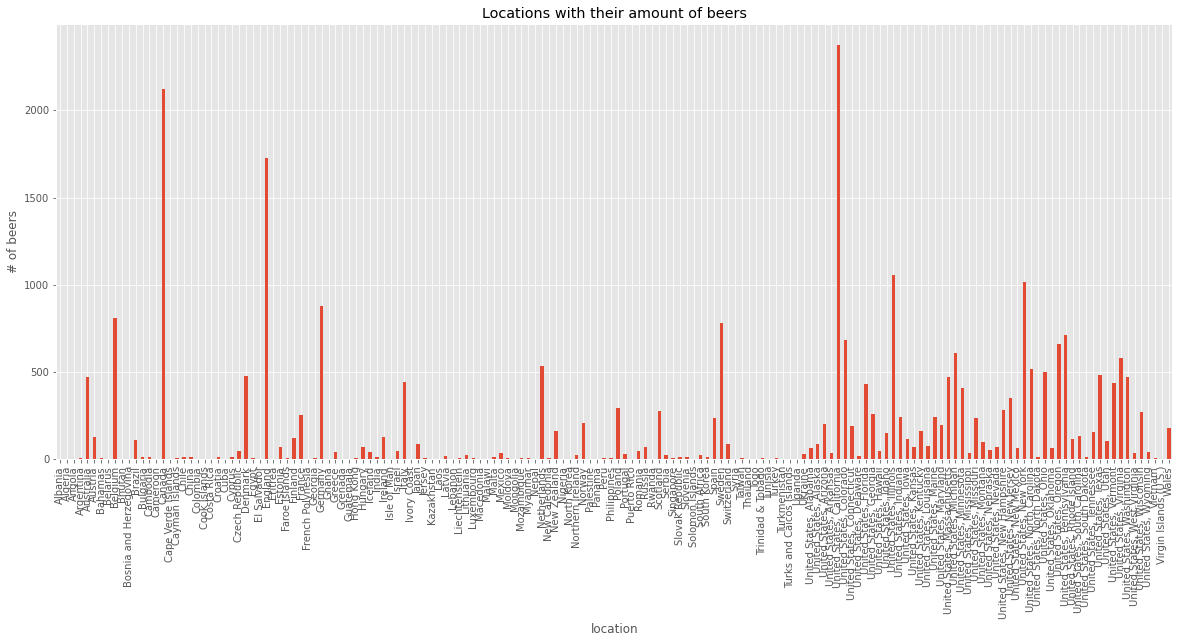

In [17]:
#Drop the beers with no zscore in either sites
df_beer_breweries_clean_5_plus = df_beer_breweries_clean_5_plus.drop(df_beer_breweries_clean_5_plus[(df_beer_breweries_clean_5_plus['zscore'].isna()) | (df_beer_breweries_clean_5_plus['zscore.1'].isna())].index)

#Drop the location with less than 5 beers (to do a beer trip, we need to have different beer to drink!)
df_beer_breweries_flt = df_beer_breweries_clean_5_plus.groupby('location').filter(lambda x: len(x) >= 5)

#Plot the location with more than 5 beers produced and with at least 5 ratings on each sites
pl = df_beer_breweries_clean_5_plus_4plot['beer_name'].plot(kind='bar', figsize=[20,8])
pl.set_title('Locations with their amount of beers')
pl.set_ylabel('# of beers')
pl.set_xlabel('location')
pl.set_xticklabels(df_beer_breweries_clean_5_plus_4plot.index, rotation=90)


We still have 112 destinations for our trip. It is a good number to start with! Now lets analysis the data relatively to the ratings and the best way is to analyse the zscore of the beers. Indeed, the z-score basically makes the ratings comparable both across websites and time in general. However, in order to have a representative overall zscore, we will average the ones from BeerAdvocate and Rate Beer by taking into account their amount of ratings. 

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
"United States, Maine",231.0,0.183846,0.473111,-1.518077,-0.102519,0.166365,0.513198,1.362519
"United States, Vermont",426.0,0.125832,0.574776,-1.837734,-0.237652,0.133906,0.563873,1.516792
"United States, California",2320.0,0.107166,0.515948,-3.199859,-0.203632,0.129826,0.466887,1.415517
"United States, New Mexico",61.0,0.062844,0.617193,-1.590671,-0.326977,0.114137,0.559598,1.172282
"United States, Georgia",253.0,0.045996,0.462134,-1.311436,-0.247329,0.045842,0.353078,1.344551
Estonia,59.0,0.036721,0.567130,-1.118227,-0.462741,0.026469,0.432350,1.091648
"United States, Alaska",87.0,0.006421,0.462141,-1.320580,-0.279923,-0.025459,0.331573,1.052375
"United States, New York",996.0,-0.011019,0.469878,-1.680847,-0.293767,0.026104,0.321323,1.077818
"United States, Illinois",1029.0,-0.037431,0.429992,-2.416453,-0.295651,-0.026500,0.250733,1.230551


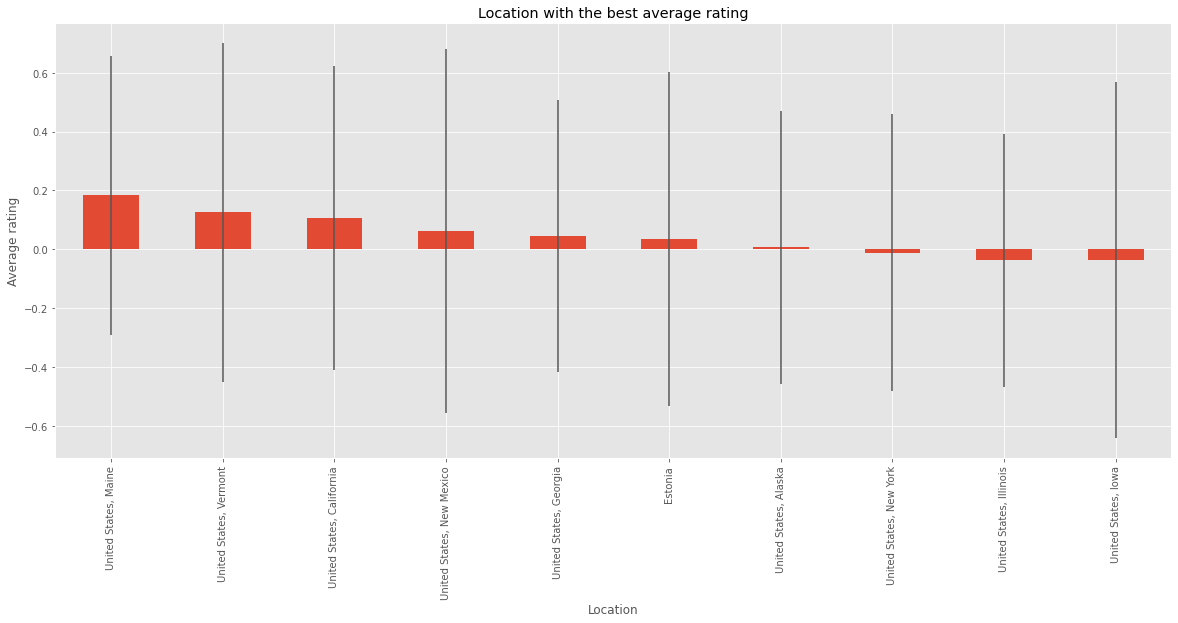

In [18]:
#Compute the beers'average rating on the two website by creating new columns
df_beer_breweries_flt['total_rating'] = df_beer_breweries_flt['nbr_ratings'] + df_beer_breweries_flt['nbr_ratings.1']
df_beer_breweries_flt['zscore_common'] = df_beer_breweries_flt['nbr_ratings']/df_beer_breweries_flt['total_rating'] * df_beer_breweries_flt['zscore'] + df_beer_breweries_flt['nbr_ratings.1'] / df_beer_breweries_flt['total_rating'] * df_beer_breweries_flt['zscore.1']


#Sort the dataframe by considering the 10 location with the best average rating
avg_rating_location = df_beer_breweries_flt.groupby('location').zscore_common.describe()
avg_rating_location.sort_values(by='mean', ascending=False, inplace=True)
top_ten_best = avg_rating_location.head(10)
display(top_ten_best)


#Plot the result with stndard deviation as error bar
pl = top_ten_best['mean'].plot(kind='bar', figsize=[20,8], rot=0, yerr=top_ten_best['std'])
pl.set_title('Location with the best average rating')
pl.set_ylabel('Average rating')
pl.set_xlabel('Location')
pl.set_xticklabels(top_ten_best.index, rotation=90)

#Keep a copy the ranking 
top_ten_best_only_location = top_ten_best.index 



As we can see on the barplot above, the standard deviation in each location is quite huge. It shows that is a location, there are well-rated beers, but also some that are badly rated. The precision of this not good, but still give a good idea of the regions where the overall ratings of the beers is high.

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
India,9.0,-2.288825,0.872045,-3.551164,-2.801557,-2.365467,-1.955389,-0.715524
Turkey,8.0,-2.184292,0.723807,-3.099231,-2.641925,-2.092501,-1.892948,-0.877841
Trinidad & Tobago,7.0,-2.012406,1.132839,-2.687124,-2.611628,-2.351946,-2.164243,0.503969
Bahamas,6.0,-1.680188,0.737527,-2.177367,-2.150897,-2.010967,-1.549750,-0.288275
Philippines,5.0,-1.486746,0.499785,-1.788784,-1.770752,-1.681783,-1.588225,-0.604184
Faroe Islands,6.0,-1.463507,0.462709,-1.911502,-1.825751,-1.559192,-1.223854,-0.724477
Lithuania,23.0,-1.425476,0.630819,-2.724032,-1.868994,-1.269317,-0.941136,-0.392230
Cayman Islands,5.0,-1.403978,0.967026,-2.505088,-1.987803,-1.525055,-1.021435,0.019492
Taiwan,5.0,-1.201023,1.079984,-2.994090,-1.257439,-0.974745,-0.587663,-0.191180


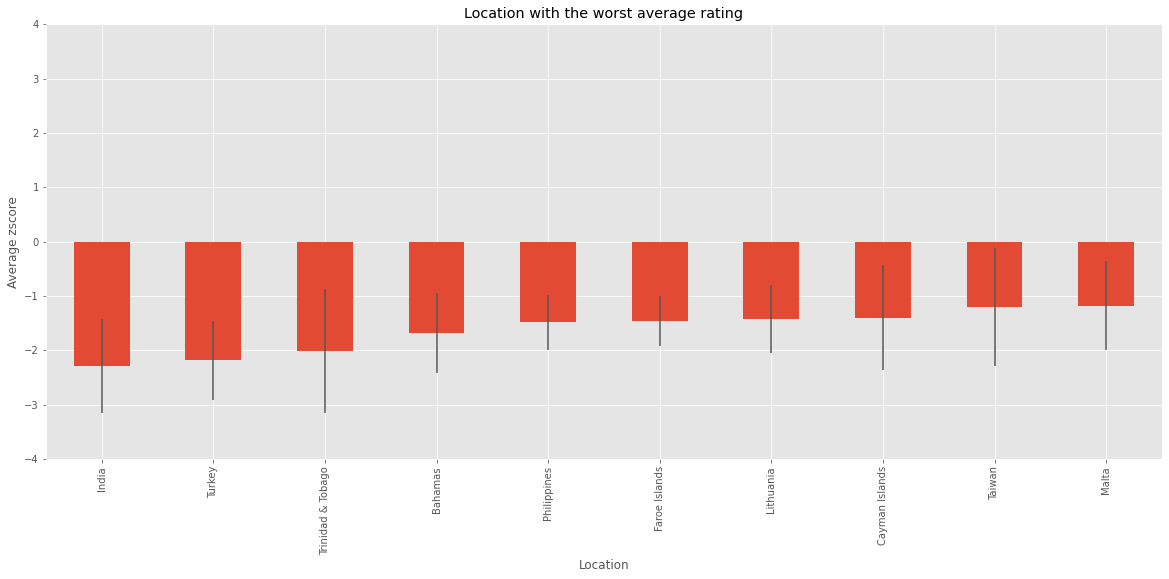

In [19]:
#Sorted the location considering the 10 location with the worst average rating and plot the result
avg_rating_location = df_beer_breweries_flt.groupby('location').zscore_common.describe()
avg_rating_location.sort_values(by='mean', ascending=True, inplace=True)
top_ten_worst = avg_rating_location.head(10)
display(top_ten_worst)


#Plot the result with stndard deviation as error bar
pl = top_ten_worst['mean'].plot(kind='bar', figsize=[20,8], rot=0, yerr=top_ten_worst['std'])
pl.set_title('Location with the worst average rating')
pl.set_ylabel('Average zscore')
pl.set_xlabel('Location')
pl.set_xticklabels(top_ten_worst.index, rotation=90)
pl.set_ylim([-4, 4])

#Keep a copy the ranking 
top_ten_worst_only_location = top_ten_worst.index 


This part is more for fun, because we have access to the worst locations, so why not to have a look at it!


**BEER TRIP RELATIVELY TO THE NUMBER OF USERS**

This part is not finish yet, because we need to import a dataframe from Wikipedia with the population from every location in order to compute the amount of user per individual. Then we are going to rank the region of the world with respect to the ones having a lot of reviewers in the population (in those countries, you are more likely to find people that love beers !)

In [20]:
#To determine the locations where the population is the most passionate by beer. 
#We thought about computing the amount of reviewers per location relatively to the population of the location.
df_users_approx_flt


,location,user_id,user_name,nbr_ratings_beer_advocate,nbr_ratings_ratebeer
0,Spain,magicuenca.1185749,MAGICuenca,3,89
1,Germany,erzengel.248045,Erzengel,6,8781
2,"United States, Virginia",gendv138.695700,GenDV138,1,6240
3,"United States, Washington",nimbleprop.208928,nimbleprop,3,7452
4,Estonia,visionthing.639993,visionthing,11,5462
...,...,...,...,...,...
3336,"United States, Michigan",ypsifly.8833,ypsifly,587,1
3337,"United States, Texas",hardtarget.1712,HardTarget,1379,1
3338,"United States, Delaware",deadterry.13629,DeadTerry,1,2
3339,Vietnam,nelsonsaigon.897449,nelsonsaigon,176,1


**ILLUSTRATION OF THE TRIPS ON A MAP**

Not finish yet, it the part where we will show the trips given by each thematic. 
TO DO (for Milestone P3): 
We want to illustrate the trips relatively to the features on a map of the world to visualize well the steps of the trips. 

In [21]:
#new.location.apply(lambda x: x.split(', '))
tmp = df_beer_breweries_clean.groupby('location').size().reset_index(name='count')
new = df_beer_breweries_clean.groupby('location').avg.mean().reset_index().dropna()
#remove everything after the string United States, in the location coumn



#add the count column to the new df
new = pd.merge(new, tmp, on='location', how='left')
new = new[new['count'] > 5]

#sort new df by avg
new = new.sort_values(by=['avg'], ascending=False)

display(new, tmp)

,location,avg,count
66,Mauritius,4.950000,12
129,"United States, Maine",3.943314,363
50,Ireland,3.919448,167
155,"United States, Vermont",3.909731,699
142,"United States, New York",3.889848,1718
...,...,...,...
57,Laos,3.015000,6
70,Mozambique,2.920000,6
6,Bahamas,2.865000,6
106,Trinidad & Tobago,2.747500,8


,location,count
0,Albania,1
1,Algeria,4
2,Angola,1
3,Argentina,19
4,Australia,711
...,...,...
170,Vanuatu,2
171,Vietnam,19
172,Virgin Islands (U.S.),1
173,Wales,225


In [22]:
countries = json.load(open('../beer_data/custom.geo.json', 'r'))
countries_id_map = {}

for feature in countries['features']:
    feature['id'] = feature['properties']['name_long']
    countries_id_map[feature['properties']['name_long']] = feature['id']

new['id'] = new['location'].apply(lambda x: countries_id_map[x])

NameError: name 'json' is not defined

In [ ]:
fig =  px.choropleth(new, 
                     geojson=countries, # geojson file to use
                     locations="location", # which column to use to set the color of markers
                     color = 'avg', # color of markers can be a single color value or an iterable
                     projection="orthographic",
                     )


fig.show()

### Calculation of the overall ranking: 

This part is not finish yet, because we didn't build all the rankings (so we don't know how many weights we will need). But the idea is to ask couple questions to the customers in order to determine which rankings are important for them. Then, with respect to the answers given, we assign some weights in order to emphasize the importance of some rankings compare to the others. For the moment, we implement the function with 5 weights.

In [ ]:
#Compute the overall ranking based on the previous rankings (assume 10 rankings)
def overall_ranking(w1, w2, w3, w4, w5) :
    '''
    Plot the overall ranking based on the previous rankings and their respective weights, given by the customer. 
    The weights must be between 0 and 1 and must sum to 1.

    Args :
        w1 : weight of the ranking 1
        w2 : weight of the ranking 2
        w3 : weight of the ranking 3
        w4 : weight of the ranking 4
        w5 : weight of the ranking 5 
    '''
    # Add the point for each ranking 
    df_density_top10 = pd.DataFrame({'location': top_ten_density_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})
    df_bestratings_top10 = pd.DataFrame({'location': top_ten_best_only_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})
    df_worstratings_top10 = pd.DataFrame({'location': top_ten_worst_only_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})  
    df_strongest_abv_top10 = pd.DataFrame({'location': top_ten_abv_only_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})
    df_softest_abv_top10 = pd.DataFrame({'location': top_ten_abv_only_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})

    # Apply the weights to the score
    df_density_top10['score'] = df_density_top10['score'] * w1
    df_bestratings_top10['score'] = df_bestratings_top10['score'] * w2
    df_worstratings_top10['score'] = df_worstratings_top10['score'] * w3
    df_strongest_abv_top10['score'] = df_strongest_abv_top10['score'] * w4
    df_softest_abv_top10['score'] = df_softest_abv_top10['score'] * w5

    # Merge all the dataframes
    df_overall = pd.merge(df_density_top10, df_bestratings_top10, on='location', how='outer')
    df_overall = pd.merge(df_overall, df_worstratings_top10, on='location', how='outer')
    df_overall = pd.merge(df_overall, df_strongest_abv_top10, on='location', how='outer')
    df_overall = pd.merge(df_overall, df_softest_abv_top10, on='location', how='outer')


### TO DO : 
# change the number in Args (docstring) by the name of the rankings (ex : % of alcohol, density of breweries, etc)
# plot the overall ranking
# return a dataframe with the overall ranking location (only location, don't need the score anymore)


### Find additional useful travel informations: 

TO DO (for Milestone P3): 
After having the overall ranking, we need to find the best breweries (the ones with the best beers) in each location and also the best users (the ones with the most ratings)